In [1]:
import os
import matplotlib.pyplot as plt
files = os.listdir('../../pythia/results/bias-evals/')

In [2]:
import json
def read_file(f):
    with open('../../pythia/results/bias-evals/' + f, 'r') as f:
        return json.load(f)

In [3]:
def parse_json(f):
    data = read_file(f)
    # get all values where key contains 'english_gender' or 'open' in a new dict 
    english = {k: v for k, v in data['results'].items() if 'english_gender' in k}
    # get only the pct_stereotype key from the new dict
    english = {k: v['pct_stereotype'] for k, v in english.items()}
    # get all values where key contains 'lambada_openai' in a new dict
    openai = {k: v for k, v in data['results'].items() if 'lambada_openai' in k}
    # get only the acc key from the new dict
    openai = {k: v['acc'] for k, v in openai.items()}
    return openai

In [4]:
pythia_files = []
intervened_files = []
long_intervened_files = []
for f in files:
  if f.startswith('pythia'):
    pythia_files.append(f)
  elif f.startswith('intervention'):
    intervened_files.append(f)
  elif f.startswith('long-intervention'):
    long_intervened_files.append(f)

In [5]:
pythia_res = {}
intervened_res = {}
long_intervened_res = {}

In [6]:
sizes_pythia = []
for f in pythia_files:
    split_name = f.split('-')
    sizes_pythia.append(split_name[1])
sizes_pythia = list(set(sizes_pythia))

steps_pythia = []
for f in pythia_files:
    split_name = f.split('-')
    if split_name[1] == '350m':
        if split_name[2] != 'deduped':
            continue
    steps_pythia.append(int(split_name[3].split('_')[0][4:]))
steps_pythia = list(set(steps_pythia))

sizes_intervened = []
for f in intervened_files:
    split_name = f.split('-')
    sizes_intervened.append(split_name[1])
sizes_intervened = list(set(sizes_intervened))

steps_intervened = []
for f in intervened_files:
    split_name = f.split('-')
    steps_intervened.append(int(split_name[3].split('_')[0][4:]))
steps_intervened = list(set(steps_intervened))

sizes_long_intervened = []
for f in long_intervened_files:
    split_name = f.split('-')
    sizes_long_intervened.append(split_name[2])
sizes_long_intervened = list(set(sizes_long_intervened))

steps_long_intervened = []
for f in long_intervened_files:
    split_name = f.split('-')
    step = int(split_name[4].split('_')[0][4:])
    steps_long_intervened.append(step)
steps_long_intervened = list(set(steps_long_intervened))

In [7]:
sizes_pythia

['1.3b', '6.9b', '19m', '350m']

In [8]:
for sizes in sizes_pythia:
    for f in pythia_files:
        file_split = f.split('-')
        if file_split[1] == '350m':
            if file_split[2] != 'deduped':
                continue
        step = int(file_split[3].split('_')[0][4:])
        if file_split[1] == sizes:
            pythia_res[(sizes, step)] = parse_json(f)

In [9]:
for sizes in sizes_intervened:
    for f in intervened_files:
        file_split = f.split('-')
        step = int(file_split[3].split('_')[0][4:])
        if file_split[1] == sizes:
            intervened_res[(sizes, step)] = parse_json(f)

In [10]:
for sizes in sizes_long_intervened:
    for f in long_intervened_files:
        file_split = f.split('-')
        step = int(file_split[4].split('_')[0][4:])
        if file_split[2] == sizes:
            long_intervened_res[(sizes, step)] = parse_json(f)

In [11]:
def preprocessing_for_plotting(pythia_dict, intervention_dict, long_intervention_dict, task_name, model_sizes, connect=True, normalize=False):
    dict_pythia = {}
    dict_intervention = {}
    dict_long_intervention = {}

    for model_size in model_sizes:
        dict_pythia[model_size] = []
        dict_intervention[model_size] = []
        dict_long_intervention[model_size] = []

    # plot pythia
    for model_size in model_sizes:
        for key in pythia_dict:
            if key[0] == model_size:
                dict_pythia[model_size].append((key[1], pythia_dict[key][task_name]))

    # Sort by step
    for model_size in model_sizes:
        dict_pythia[model_size] = sorted(dict_pythia[model_size], key=lambda x: x[0])

    # normalize x[0] to 1 to 100 %
    if normalize:
        for model_size in model_sizes:
            max_step = dict_pythia[model_size][-1][0]
            dict_pythia[model_size] = [(x[0]/max_step*100, x[1]) for x in dict_pythia[model_size]]

    # plot intervention
    for model_size in model_sizes:
        for key in intervention_dict:
            if key[0] == model_size:
                dict_intervention[model_size].append((key[1], intervention_dict[key][task_name]))

    # Sort by step
    for model_size in model_sizes:
        dict_intervention[model_size] = sorted(dict_intervention[model_size], key=lambda x: x[0])

    # normalize x[0] to 1 to 100 %
    if normalize:
        for model_size in model_sizes:
            max_step = dict_intervention[model_size][-1][0]
            dict_intervention[model_size] = [(x[0]/max_step*100, x[1]) for x in dict_intervention[model_size]]

    # plot long intervention
    if long_intervention_dict is not None:
        for model_size in model_sizes:
            for key in long_intervention_dict:
                if key[0] == model_size:
                    dict_long_intervention[model_size].append((key[1], long_intervention_dict[key][task_name]))

        # Sort by step
        for model_size in model_sizes:
            dict_long_intervention[model_size] = sorted(dict_long_intervention[model_size], key=lambda x: x[0])
        # normalize x[0] to 1 to 100 %
        if normalize:
            for model_size in model_sizes:
                if dict_long_intervention[model_size] == []:
                    continue
                max_step = dict_long_intervention[model_size][-1][0]
                dict_long_intervention[model_size] = [(x[0]/max_step*100, x[1]) for x in dict_long_intervention[model_size]]

    # Find first step where intervened and long_intervened matche pythia in x[0] and choose step before that
    c1 = [0 for _ in range(len(model_sizes))]
    c2 = [0 for _ in range(len(model_sizes))]

    
    for i in range(len(model_sizes)):
        if dict_long_intervention[model_sizes[i]] != []:
            for j in range(len(dict_pythia[model_sizes[i]])):
                if dict_pythia[model_sizes[i]][j][0] >= dict_intervention[model_sizes[i]][0][0]:
                    if dict_pythia[model_sizes[i]][j][0] > dict_intervention[model_sizes[i]][0][0]:
                        c1[i] = j - 1
                    else:
                        c1[i] = j
                    break
            for j in range(len(dict_pythia[model_sizes[i]])):
                if dict_pythia[model_sizes[i]][j][0] >= dict_long_intervention[model_sizes[i]][0][0]:
                    if dict_pythia[model_sizes[i]][j][0] > dict_long_intervention[model_sizes[i]][0][0]:
                        c2[i] = j - 1
                    else:
                        c2[i] = j
                    break
        else:
            for j in range(len(dict_pythia[model_sizes[i]])):
                if dict_pythia[model_sizes[i]][j][0] >= dict_intervention[model_sizes[i]][0][0]:
                    if dict_pythia[model_sizes[i]][j][0] > dict_intervention[model_sizes[i]][0][0]:
                        c1[i] = j - 1
                    else:
                        c1[i] = j
                    break
    
    if connect:
        # Add the point at index c to the beginning of ls_intervened
        # print('Adding point', dict_pythia[c], 'to ls_intervened')
        for i in range(len(model_sizes)):
            dict_intervention[model_sizes[i]] = [dict_pythia[model_sizes[i]][c1[i]]] + dict_intervention[model_sizes[i]]
            if dict_long_intervention[model_sizes[i]] != []:
                dict_long_intervention[model_sizes[i]] = [dict_pythia[model_sizes[i]][c2[i]]] + dict_long_intervention[model_sizes[i]]

    # Keep points where key[0] is greater than dict_pythia[c][0]
    if not normalize:
        for i in range(len(model_sizes)):
            dict_intervention[model_sizes[i]] = [x for x in dict_intervention[model_sizes[i]] if x[0] > 50000]
            if dict_long_intervention[model_sizes[i]] != []:
                dict_long_intervention[model_sizes[i]] = [x for x in dict_long_intervention[model_sizes[i]] if x[0] > 50000]
            dict_pythia[model_sizes[i]] = [x for x in dict_pythia[model_sizes[i]] if x[0] > 50000]

    return dict_pythia, dict_intervention, dict_long_intervention

In [12]:
def plot_results(pythia_dict, intervention_dict, long_intervention_dict, task_name, model_sizes, save_name, connect=True, normalize=False):
    """
    Args:
        pythia_dict: dict of pythia results
        intervention_dict: dict of intervention results
        long_intervention_dict: dict of long intervention results
        task_name: name of the task
        model_sizes: list of model sizes to plot (In Order)
        save_name: name of the file to save to (Entire path)
        connect: whether to connect the first point of intervened and long intervened to the previous pythia step
        normalize: whether to normalize the x-axis to % of Training Data
    """
    dict_pythia, dict_intervention, dict_long_intervention = preprocessing_for_plotting(pythia_dict, intervention_dict, long_intervention_dict, task_name, model_sizes, connect, normalize)

    # plot
    plt.rcParams["figure.figsize"] = (15, 10)
    
    colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

    for i in range(len(model_sizes)):
        plt.plot([x[0] for x in dict_pythia[model_sizes[i]]], [x[1] for x in dict_pythia[model_sizes[i]]], label='Pythia ' + model_sizes[i].upper(), color=colors[i])
        plt.plot([x[0] for x in dict_intervention[model_sizes[i]]], [x[1] for x in dict_intervention[model_sizes[i]]], label='Intervention ' + model_sizes[i].upper(), linestyle='dotted', color=colors[i])
        if dict_long_intervention[model_sizes[i]] != []:
            plt.plot([x[0] for x in dict_long_intervention[model_sizes[i]]], [x[1] for x in dict_long_intervention[model_sizes[i]]], label='Long Intervention ' + model_sizes[i].upper(), linestyle='dashdot', color=colors[i])

    plt.xlabel('Steps')
    plt.ylabel('Accuracy')
    # Font size
    plt.rcParams.update({'font.size': 15})
    # Line width
    plt.rcParams['lines.linewidth'] = 3
    # x Label and Y Label Font
    plt.rcParams['axes.labelsize'] = 25
    # x and y Ticks Font
    plt.rcParams['xtick.labelsize'] = 20
    plt.rcParams['ytick.labelsize'] = 20
    # Legend Font
    plt.rcParams['legend.fontsize'] = 22
    plt.legend()
    # plt.show()
    # Save the plot
    plt.savefig(save_name, format='pdf')

In [13]:
# plot_results(pythia_res,
#              intervened_res,
#              long_intervened_res,
#              'lambada_openai',
#              ['19m'],
#              'lambada_openai_plots/' + 'lambada_openai_19m.pdf', normalize=True)

In [14]:
# plot_results(pythia_res,
#              intervened_res,
#              long_intervened_res,
#              'lambada_openai',
#              ['6.9b'],
#              'lambada_openai_plots/' + 'lambada_openai_6.9b.pdf')

In [15]:
# plot_results(pythia_res,
#              intervened_res,
#              long_intervened_res,
#              'lambada_openai',
#              ['350m'],
#              'lambada_openai_plots/' + 'lambada_openai_350m.pdf')

In [16]:
# plot_results(pythia_res,
#              intervened_res,
#              long_intervened_res,
#              'lambada_openai',
#              ['1.3b'],
#              'lambada_openai_plots/' + 'lambada_openai_1.3b.pdf')

In [17]:
def plot_results_shared_axes(pythia_dict, intervention_dict, long_intervention_dict, task_name, model_sizes, save_name, connect=True, normalize=False):
    """
    Args:
        pythia_dict: dict of pythia results
        intervention_dict: dict of intervention results
        long_intervention_dict: dict of long intervention results
        task_name: name of the task
        model_sizes: 2D list with each sublist containing model sizes to plot (In Order)
        save_name: name of the file to save to (Entire path)
        connect: whether to connect the first point of intervened and long intervened to the previous pythia step
        normalize: whether to normalize the x-axis to % of Training Data
    """
    dict_pythia_1, dict_intervention_1, dict_long_intervention_1 = preprocessing_for_plotting(pythia_dict, intervention_dict, long_intervention_dict, task_name, model_sizes[0], connect, normalize)
    dict_pythia_2, dict_intervention_2, dict_long_intervention_2 = preprocessing_for_plotting(pythia_dict, intervention_dict, long_intervention_dict, task_name, model_sizes[1], connect, normalize)

    # plot
    plt.rcParams["figure.figsize"] = (30, 10)
    
    colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

    # Create 2 subplots sharing y axis
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

    for i in range(len(model_sizes[0])):
        ax1.plot([x[0] for x in dict_pythia_1[model_sizes[0][i]]], [x[1] for x in dict_pythia_1[model_sizes[0][i]]], label='Pythia ' + model_sizes[0][i].upper(), color=colors[i])
        ax1.plot([x[0] for x in dict_intervention_1[model_sizes[0][i]]], [x[1] for x in dict_intervention_1[model_sizes[0][i]]], label='Intervention ' + model_sizes[0][i].upper(), linestyle='dotted', color=colors[i])
        if dict_long_intervention_1[model_sizes[0][i]] != []:
            ax1.plot([x[0] for x in dict_long_intervention_1[model_sizes[0][i]]], [x[1] for x in dict_long_intervention_1[model_sizes[0][i]]], label='Long Intervention ' + model_sizes[0][i].upper(), linestyle='dashdot', color=colors[i])
    
    for i in range(len(model_sizes[1])):
        ax2.plot([x[0] for x in dict_pythia_2[model_sizes[1][i]]], [x[1] for x in dict_pythia_2[model_sizes[1][i]]], label='Pythia ' + model_sizes[1][i].upper(), color=colors[i])
        ax2.plot([x[0] for x in dict_intervention_2[model_sizes[1][i]]], [x[1] for x in dict_intervention_2[model_sizes[1][i]]], label='Intervention ' + model_sizes[1][i].upper(), linestyle='dotted', color=colors[i])
        if dict_long_intervention_2[model_sizes[1][i]] != []:
            ax2.plot([x[0] for x in dict_long_intervention_2[model_sizes[1][i]]], [x[1] for x in dict_long_intervention_2[model_sizes[1][i]]], label='Long Intervention ' + model_sizes[1][i].upper(), linestyle='dashdot', color=colors[i])

    ax1.set_xlabel('Steps')
    ax1.set_ylabel('Accuracy')
    ax2.set_xlabel('Steps')
    ax2.set_ylabel('Accuracy')

    # Show Both Legends
    ax1.legend()
    ax2.legend()

    # Font size
    plt.rcParams.update({'font.size': 15})
    # Line width
    plt.rcParams['lines.linewidth'] = 3
    plt.legend()
    # plt.show()
    # Save the plot
    plt.savefig(save_name, format='pdf')

In [18]:
# plot_results_shared_axes(pythia_res,
#              intervened_res,
#              long_intervened_res,
#              'lambada_openai',
#                 [['350m', '1.3b'], ['19m','6.9b']],
#              'lambada_openai_plots/' + 'lambada_openai_shared_axes.pdf')

In [22]:
def plot_results_shared_x_axes(pythia_dict, intervention_dict, long_intervention_dict, task_name, model_sizes, save_name, connect=True, normalize=False):
    """
    Args:
        pythia_dict: dict of pythia results
        intervention_dict: dict of intervention results
        long_intervention_dict: dict of long intervention results
        task_name: name of the task
        model_sizes: 2D list with each sublist containing model sizes to plot (In Order)
        save_name: name of the file to save to (Entire path)
        connect: whether to connect the first point of intervened and long intervened to the previous pythia step
        normalize: whether to normalize the x-axis to % of Training Data
    """
    dict_pythia_1, dict_intervention_1, dict_long_intervention_1 = preprocessing_for_plotting(pythia_dict, intervention_dict, long_intervention_dict, task_name, model_sizes[0], connect, normalize)
    dict_pythia_2, dict_intervention_2, dict_long_intervention_2 = preprocessing_for_plotting(pythia_dict, intervention_dict, long_intervention_dict, task_name, model_sizes[1], connect, normalize)

    # plot
    plt.rcParams["figure.figsize"] = (30, 20)
    
    colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

    # Create 2 subplots sharing y axis
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

    for i in range(len(model_sizes[0])):

        updated_size = ""
        if model_sizes[0][i] == '19m':
            updated_size = '70M'
        elif model_sizes[0][i] == '350m':
            updated_size = '400M'
        elif model_sizes[0][i] == '1.3b':
            updated_size = '1.4B'
        else:
            updated_size = model_sizes[0][i].upper()

        ax1.plot([x[0] for x in dict_pythia_1[model_sizes[0][i]]], [x[1] for x in dict_pythia_1[model_sizes[0][i]]], label='Pythia ' + updated_size, color=colors[0])
        ax1.plot([x[0] for x in dict_intervention_1[model_sizes[0][i]]], [x[1] for x in dict_intervention_1[model_sizes[0][i]]], label='Intervention ' + updated_size, linestyle='dotted', color=colors[0])
        if dict_long_intervention_1[model_sizes[0][i]] != []:
            ax1.plot([x[0] for x in dict_long_intervention_1[model_sizes[0][i]]], [x[1] for x in dict_long_intervention_1[model_sizes[0][i]]], label='Long Intervention ' + updated_size, linestyle='dashdot', color=colors[0])
    
    for i in range(len(model_sizes[1])):

        updated_size = ""
        if model_sizes[1][i] == '19m':
            updated_size = '70M'
        elif model_sizes[1][i] == '350m':
            updated_size = '400M'
        elif model_sizes[1][i] == '1.3b':
            updated_size = '1.4B'
        else:
            updated_size = model_sizes[1][i].upper()

        ax2.plot([x[0] for x in dict_pythia_2[model_sizes[1][i]]], [x[1] for x in dict_pythia_2[model_sizes[1][i]]], label='Pythia ' +updated_size, color=colors[1])
        ax2.plot([x[0] for x in dict_intervention_2[model_sizes[1][i]]], [x[1] for x in dict_intervention_2[model_sizes[1][i]]], label='Intervention ' + updated_size, linestyle='dotted', color=colors[1])
        if dict_long_intervention_2[model_sizes[1][i]] != []:
            ax2.plot([x[0] for x in dict_long_intervention_2[model_sizes[1][i]]], [x[1] for x in dict_long_intervention_2[model_sizes[1][i]]], label='Long Intervention ' +updated_size, linestyle='dashdot', color=colors[1])

    ax1.set_xlabel('Steps')
    ax1.set_ylabel('Accuracy')
    ax2.set_xlabel('Steps')
    ax2.set_ylabel('Accuracy')

    # Show Both Legends
    ax1.legend()
    ax2.legend()
    # Font size
    plt.rcParams.update({'font.size': 15})
    # Line width
    plt.rcParams['lines.linewidth'] = 3
    # x Label and Y Label Font
    plt.rcParams['axes.labelsize'] = 30
    # x and y Ticks Font
    plt.rcParams['xtick.labelsize'] = 30
    plt.rcParams['ytick.labelsize'] = 30
    # Axis Label Font
    plt.rcParams['axes.labelsize'] = 30
    # Legend Font
    plt.rcParams['legend.fontsize'] = 30
    plt.legend()
    # plt.show()
    # Save the plot
    plt.savefig(save_name, format='pdf')

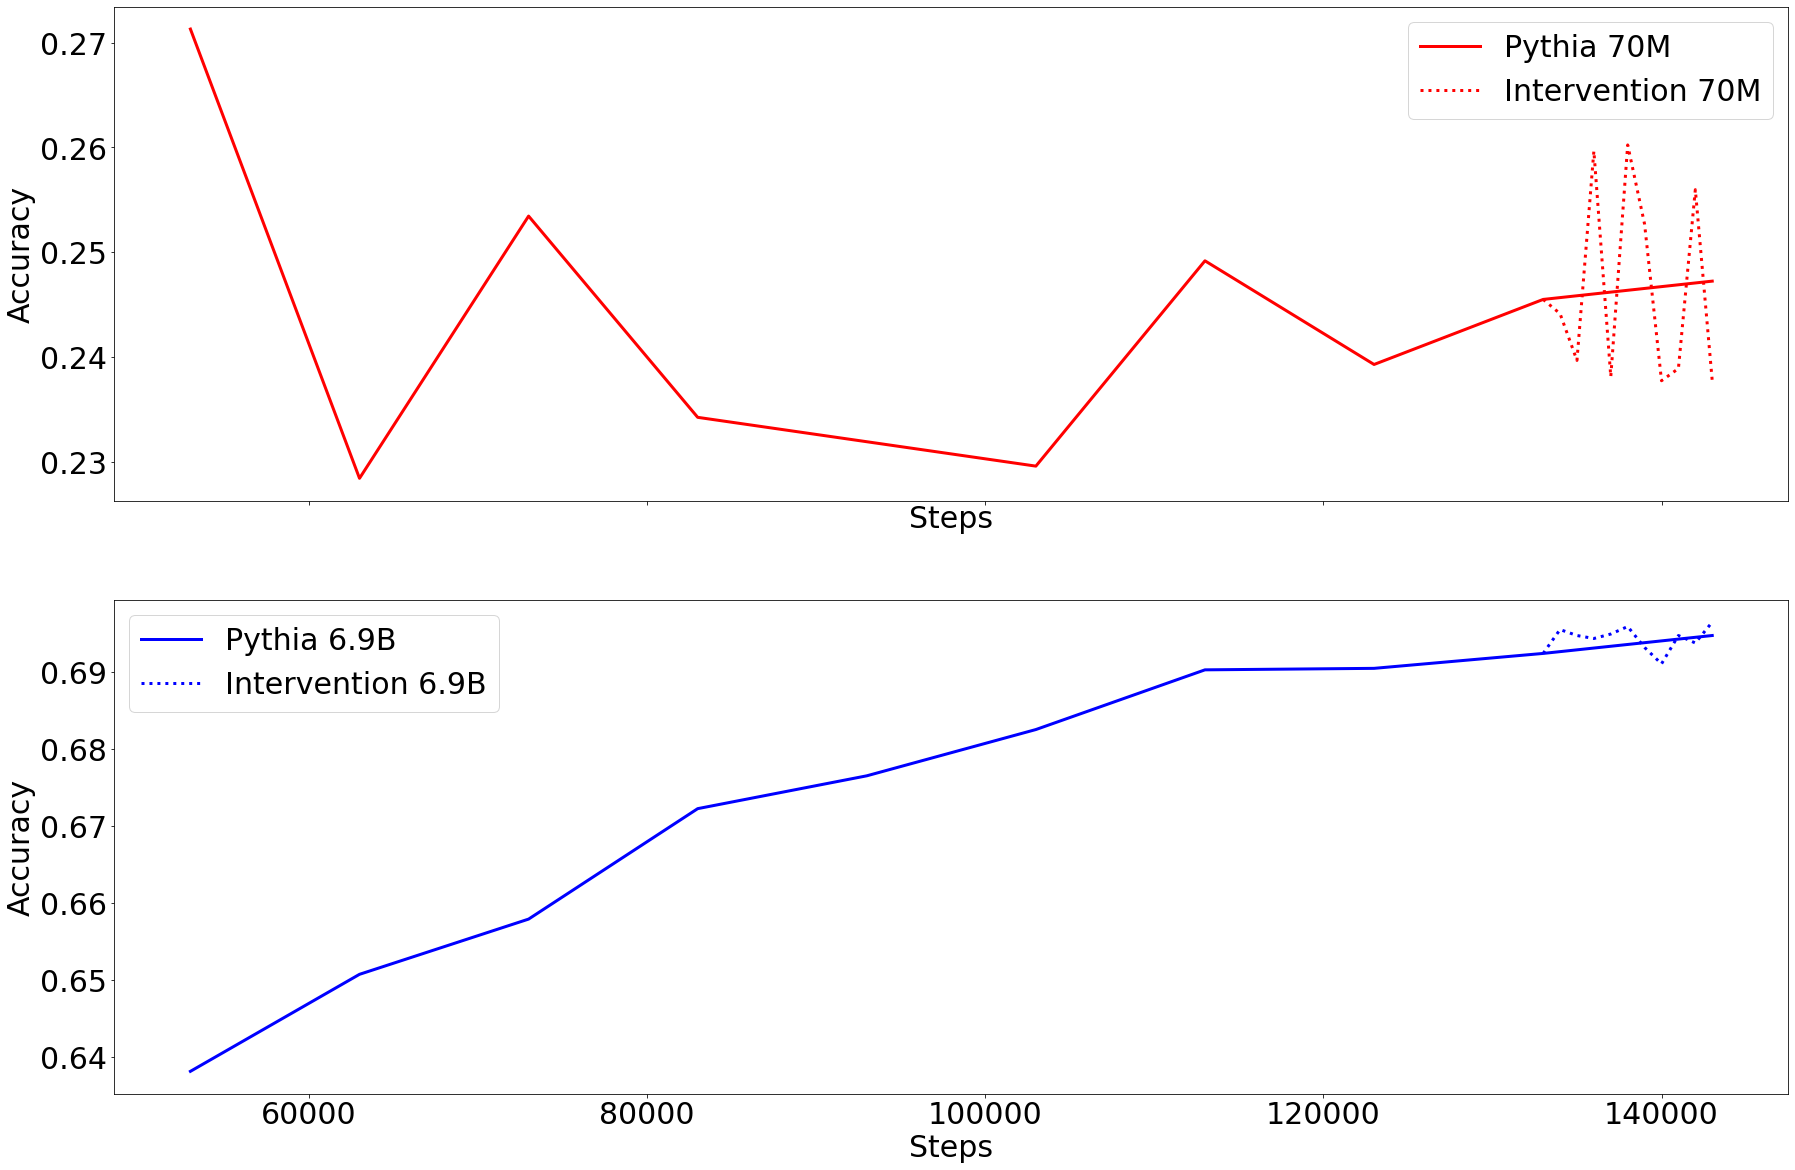

In [26]:
plot_results_shared_x_axes(pythia_res, intervened_res, long_intervened_res, 'lambada_openai', [['19m'], ['6.9b']], 'lambada_openai_plots/lambada_openai_70M_6.9B_vstack.pdf')

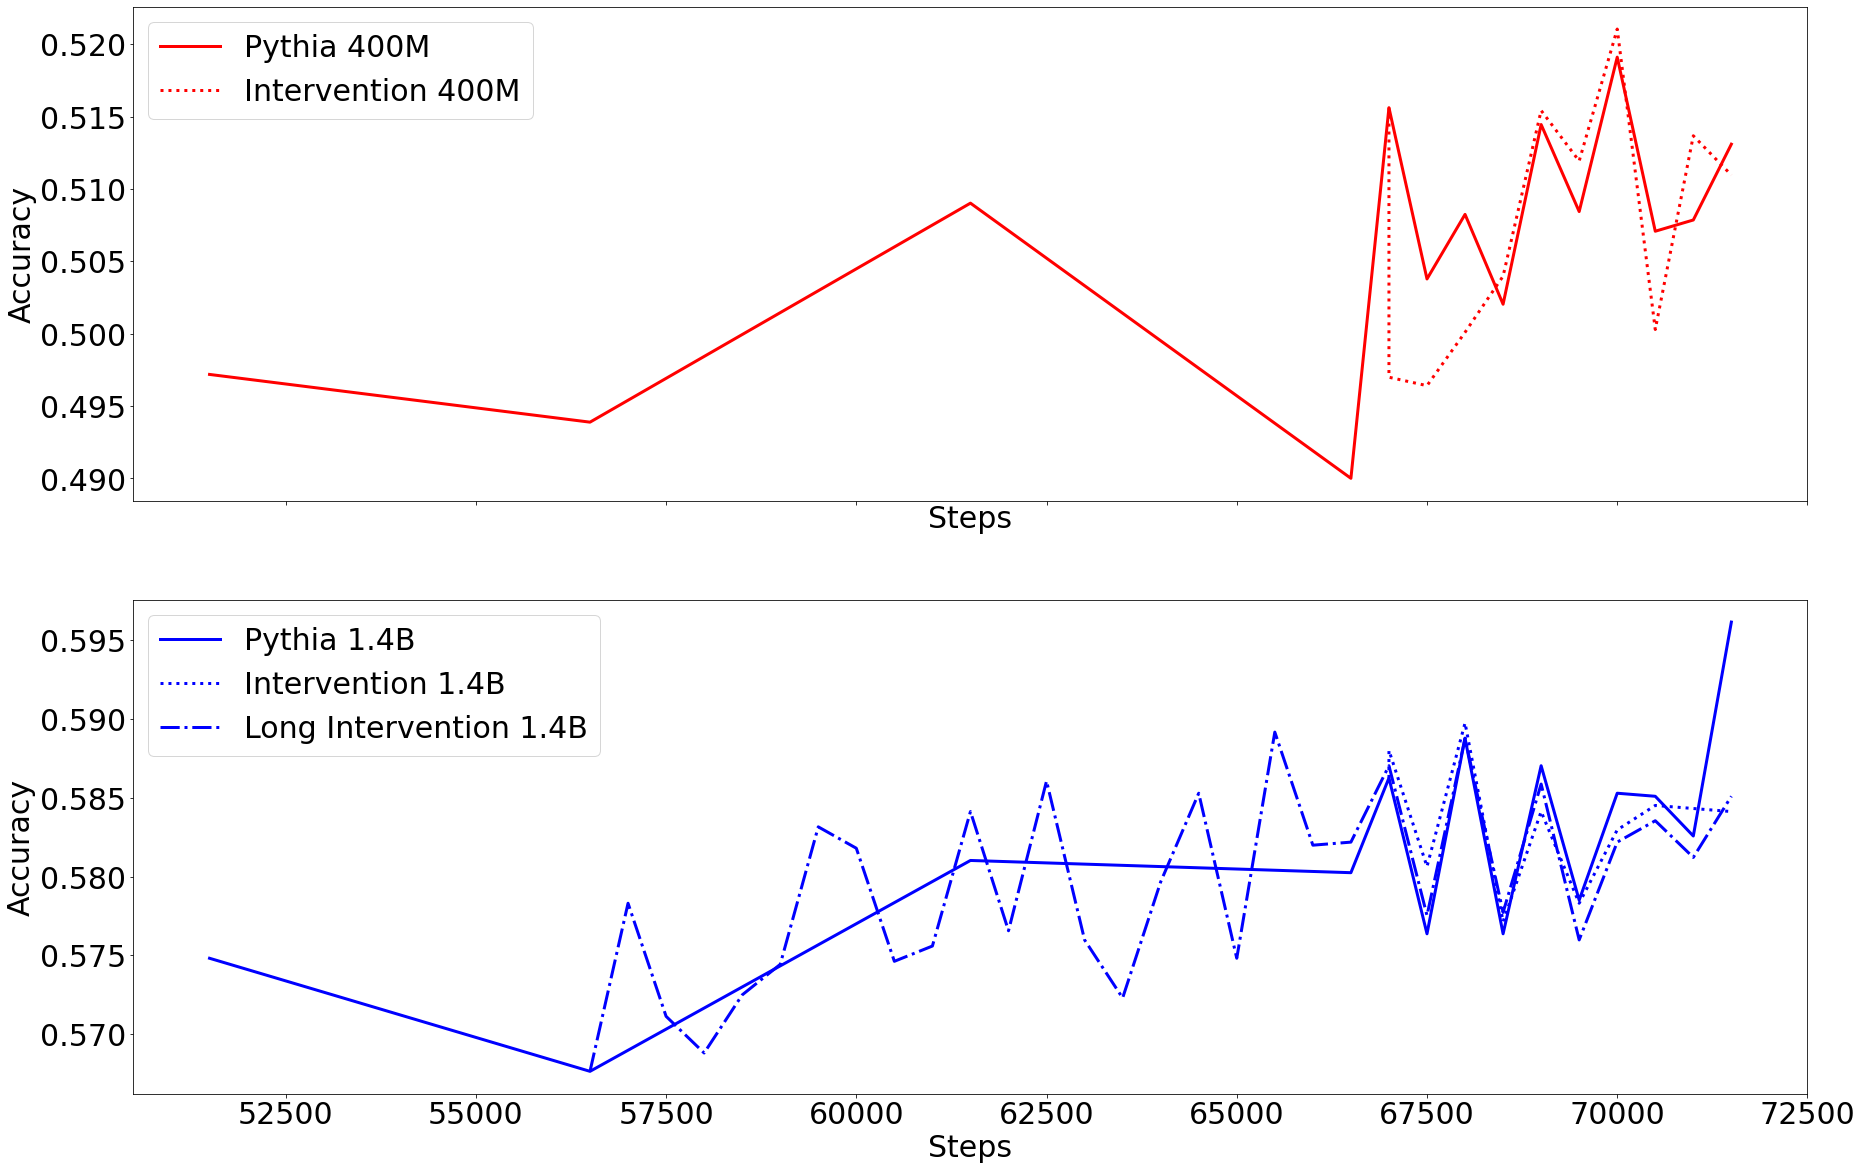

In [27]:
plot_results_shared_x_axes(pythia_res, intervened_res, long_intervened_res, 'lambada_openai', [['350m'], ['1.3b']], 'lambada_openai_plots/lambada_openai_400M_1.4B_vstack.pdf')

In [191]:
def plot_4_subplots(pythia_dict, intervention_dict, long_intervention_dict, task_name, model_sizes, save_name, connect=True, normalize=False):
    """
    Args:
        pythia_dict: dict of pythia results
        intervention_dict: dict of intervention results
        long_intervention_dict: dict of long intervention results
        task_name: name of the task
        model_sizes: 2D List with each entry list having the model sizes to plot
        save_name: name of the file to save to (Entire path)
        connect: whether to connect the first point of intervened and long intervened to the previous pythia step
        normalize: whether to normalize the x-axis to % of Training Data
    """
    dict_pythia_1, dict_intervention_1, dict_long_intervention_1 = preprocessing_for_plotting(pythia_dict, intervention_dict, long_intervention_dict, task_name, model_sizes[0], connect, normalize)
    dict_pythia_2, dict_intervention_2, dict_long_intervention_2 = preprocessing_for_plotting(pythia_dict, intervention_dict, long_intervention_dict, task_name, model_sizes[1], connect, normalize)
    dict_pythia_3, dict_intervention_3, dict_long_intervention_3 = preprocessing_for_plotting(pythia_dict, intervention_dict, long_intervention_dict, task_name, model_sizes[2], connect, normalize)
    dict_pythia_4, dict_intervention_4, dict_long_intervention_4 = preprocessing_for_plotting(pythia_dict, intervention_dict, long_intervention_dict, task_name, model_sizes[3], connect, normalize)

    # plot
    plt.rcParams["figure.figsize"] = (30, 20)
    
    colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

    # Create 2 subplots sharing x axis in sets of 2
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True)

    for i in range(len(model_sizes[0])):
        ax1.plot([x[0] for x in dict_pythia_1[model_sizes[0][i]]], [x[1] for x in dict_pythia_1[model_sizes[0][i]]], label='Pythia ' + model_sizes[0][i].upper(), color=colors[0])
        ax1.plot([x[0] for x in dict_intervention_1[model_sizes[0][i]]], [x[1] for x in dict_intervention_1[model_sizes[0][i]]], label='Intervention ' + model_sizes[0][i].upper(), linestyle='dotted', color=colors[0])
        if dict_long_intervention_1[model_sizes[0][i]] != []:
            ax1.plot([x[0] for x in dict_long_intervention_1[model_sizes[0][i]]], [x[1] for x in dict_long_intervention_1[model_sizes[0][i]]], label='Long Intervention ' + model_sizes[0][i].upper(), linestyle='dashdot', color=colors[0])
    
    for i in range(len(model_sizes[1])):
        ax2.plot([x[0] for x in dict_pythia_2[model_sizes[1][i]]], [x[1] for x in dict_pythia_2[model_sizes[1][i]]], label='Pythia ' + model_sizes[1][i].upper(), color=colors[1])
        ax2.plot([x[0] for x in dict_intervention_2[model_sizes[1][i]]], [x[1] for x in dict_intervention_2[model_sizes[1][i]]], label='Intervention ' + model_sizes[1][i].upper(), linestyle='dotted', color=colors[1])
        if dict_long_intervention_2[model_sizes[1][i]] != []:
            ax2.plot([x[0] for x in dict_long_intervention_2[model_sizes[1][i]]], [x[1] for x in dict_long_intervention_2[model_sizes[1][i]]], label='Long Intervention ' + model_sizes[1][i].upper(), linestyle='dashdot', color=colors[1])

    for i in range(len(model_sizes[2])):
        ax3.plot([x[0] for x in dict_pythia_3[model_sizes[2][i]]], [x[1] for x in dict_pythia_3[model_sizes[2][i]]], label='Pythia ' + model_sizes[2][i].upper(), color=colors[2])
        ax3.plot([x[0] for x in dict_intervention_3[model_sizes[2][i]]], [x[1] for x in dict_intervention_3[model_sizes[2][i]]], label='Intervention ' + model_sizes[2][i].upper(), linestyle='dotted', color=colors[2])
        if dict_long_intervention_3[model_sizes[2][i]] != []:
            ax3.plot([x[0] for x in dict_long_intervention_3[model_sizes[2][i]]], [x[1] for x in dict_long_intervention_3[model_sizes[2][i]]], label='Long Intervention ' + model_sizes[2][i].upper(), linestyle='dashdot', color=colors[2])

    for i in range(len(model_sizes[3])):
        ax4.plot([x[0] for x in dict_pythia_4[model_sizes[3][i]]], [x[1] for x in dict_pythia_4[model_sizes[3][i]]], label='Pythia ' + model_sizes[3][i].upper(), color=colors[3])
        ax4.plot([x[0] for x in dict_intervention_4[model_sizes[3][i]]], [x[1] for x in dict_intervention_4[model_sizes[3][i]]], label='Intervention ' + model_sizes[3][i].upper(), linestyle='dotted', color=colors[3])
        if dict_long_intervention_4[model_sizes[3][i]] != []:
            ax4.plot([x[0] for x in dict_long_intervention_4[model_sizes[3][i]]], [x[1] for x in dict_long_intervention_4[model_sizes[3][i]]], label='Long Intervention ' + model_sizes[3][i].upper(), linestyle='dashdot', color=colors[3])

    ax1.set_xlabel('Steps')
    ax1.set_ylabel('Accuracy')
    ax2.set_xlabel('Steps')
    ax2.set_ylabel('Accuracy')
    ax3.set_xlabel('Steps')
    ax3.set_ylabel('Accuracy')
    ax4.set_xlabel('Steps')
    ax4.set_ylabel('Accuracy')

    # Show Both Legends
    ax1.legend()
    ax2.legend()
    ax3.legend()
    ax4.legend()

    # # Set X Ticks Range for Subplot 1 and 4
    # ax1.set_xlim(50000, 80000)
    # ax4.set_xlim(50000, 80000)

    # ax2.set_xlim(50000, 100000)

    # Font size
    plt.rcParams.update({'font.size': 15})
    # Line width
    plt.rcParams['lines.linewidth'] = 3
    plt.legend()
    # plt.show()
    # Save the plot
    plt.savefig(save_name, format='pdf')

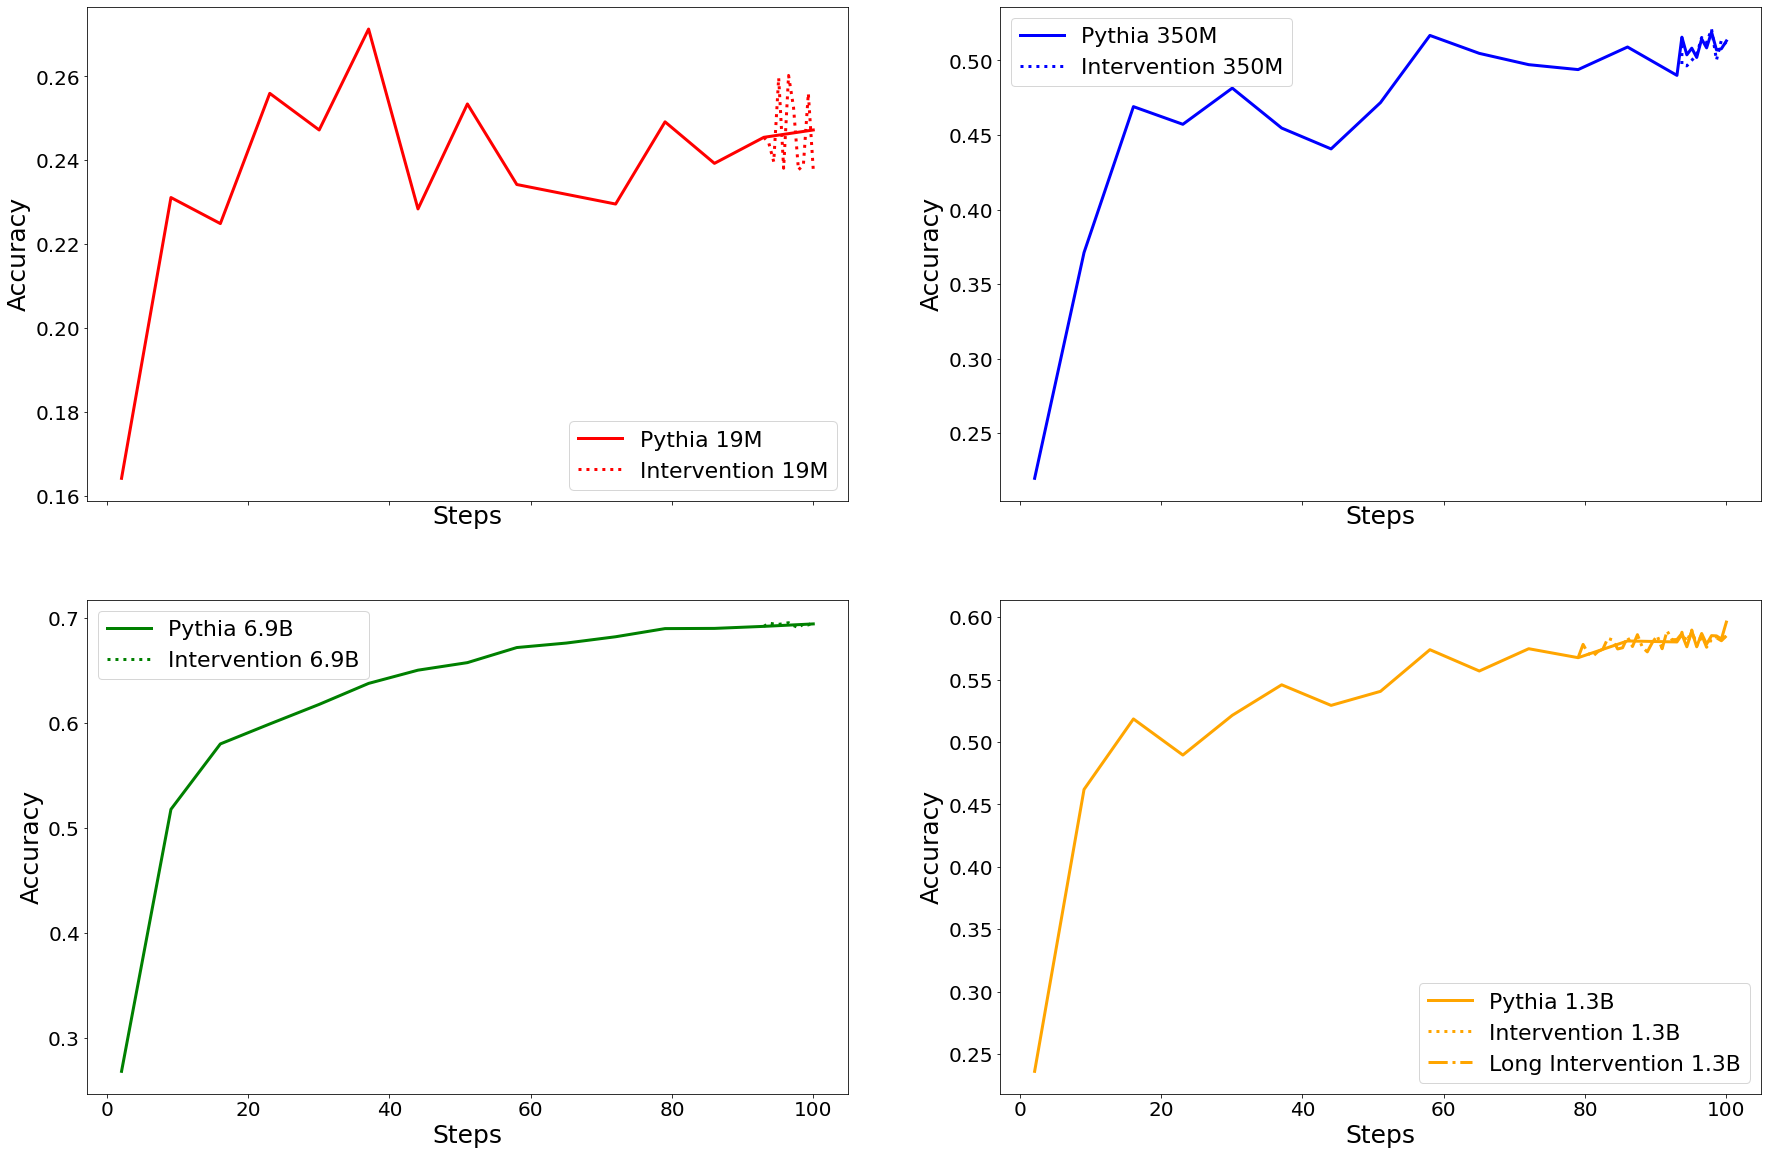

In [192]:
# plot_4_subplots(pythia_res, intervened_res, long_intervened_res, 'lambada_openai', [['19m'], ['350m'], ['6.9b'], ['1.3b']], 'lambada_openai_plots/lambada_openai_4_plots.pdf', normalize=True)

In [199]:
def plot_4_subplots_stackv(pythia_dict, intervention_dict, long_intervention_dict, task_name, model_sizes, save_name, connect=True, normalize=False):
    """
    Args:
        pythia_dict: dict of pythia results
        intervention_dict: dict of intervention results
        long_intervention_dict: dict of long intervention results
        task_name: name of the task
        model_sizes: 2D List with each entry list having the model sizes to plot
        save_name: name of the file to save to (Entire path)
        connect: whether to connect the first point of intervened and long intervened to the previous pythia step
        normalize: whether to normalize the x-axis to % of Training Data
    """
    dict_pythia_1, dict_intervention_1, dict_long_intervention_1 = preprocessing_for_plotting(pythia_dict, intervention_dict, long_intervention_dict, task_name, model_sizes[0], connect, normalize)
    dict_pythia_2, dict_intervention_2, dict_long_intervention_2 = preprocessing_for_plotting(pythia_dict, intervention_dict, long_intervention_dict, task_name, model_sizes[1], connect, normalize)
    dict_pythia_3, dict_intervention_3, dict_long_intervention_3 = preprocessing_for_plotting(pythia_dict, intervention_dict, long_intervention_dict, task_name, model_sizes[2], connect, normalize)
    dict_pythia_4, dict_intervention_4, dict_long_intervention_4 = preprocessing_for_plotting(pythia_dict, intervention_dict, long_intervention_dict, task_name, model_sizes[3], connect, normalize)

    # plot
    plt.rcParams["figure.figsize"] = (30, 50)
    
    colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

    # Create 2 subplots sharing x axis in sets of 2
    fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(4, 1, sharex=True)

    for i in range(len(model_sizes[0])):
        ax1.plot([x[0] for x in dict_pythia_1[model_sizes[0][i]]], [x[1] for x in dict_pythia_1[model_sizes[0][i]]], label='Pythia ' + model_sizes[0][i].upper(), color=colors[0])
        ax1.plot([x[0] for x in dict_intervention_1[model_sizes[0][i]]], [x[1] for x in dict_intervention_1[model_sizes[0][i]]], label='Intervention ' + model_sizes[0][i].upper(), linestyle='dotted', color=colors[0])
        if dict_long_intervention_1[model_sizes[0][i]] != []:
            ax1.plot([x[0] for x in dict_long_intervention_1[model_sizes[0][i]]], [x[1] for x in dict_long_intervention_1[model_sizes[0][i]]], label='Long Intervention ' + model_sizes[0][i].upper(), linestyle='dashdot', color=colors[0])
    
    for i in range(len(model_sizes[1])):
        ax2.plot([x[0] for x in dict_pythia_2[model_sizes[1][i]]], [x[1] for x in dict_pythia_2[model_sizes[1][i]]], label='Pythia ' + model_sizes[1][i].upper(), color=colors[1])
        ax2.plot([x[0] for x in dict_intervention_2[model_sizes[1][i]]], [x[1] for x in dict_intervention_2[model_sizes[1][i]]], label='Intervention ' + model_sizes[1][i].upper(), linestyle='dotted', color=colors[1])
        if dict_long_intervention_2[model_sizes[1][i]] != []:
            ax2.plot([x[0] for x in dict_long_intervention_2[model_sizes[1][i]]], [x[1] for x in dict_long_intervention_2[model_sizes[1][i]]], label='Long Intervention ' + model_sizes[1][i].upper(), linestyle='dashdot', color=colors[1])

    for i in range(len(model_sizes[2])):
        ax3.plot([x[0] for x in dict_pythia_3[model_sizes[2][i]]], [x[1] for x in dict_pythia_3[model_sizes[2][i]]], label='Pythia ' + model_sizes[2][i].upper(), color=colors[2])
        ax3.plot([x[0] for x in dict_intervention_3[model_sizes[2][i]]], [x[1] for x in dict_intervention_3[model_sizes[2][i]]], label='Intervention ' + model_sizes[2][i].upper(), linestyle='dotted', color=colors[2])
        if dict_long_intervention_3[model_sizes[2][i]] != []:
            ax3.plot([x[0] for x in dict_long_intervention_3[model_sizes[2][i]]], [x[1] for x in dict_long_intervention_3[model_sizes[2][i]]], label='Long Intervention ' + model_sizes[2][i].upper(), linestyle='dashdot', color=colors[2])

    for i in range(len(model_sizes[3])):
        ax4.plot([x[0] for x in dict_pythia_4[model_sizes[3][i]]], [x[1] for x in dict_pythia_4[model_sizes[3][i]]], label='Pythia ' + model_sizes[3][i].upper(), color=colors[3])
        ax4.plot([x[0] for x in dict_intervention_4[model_sizes[3][i]]], [x[1] for x in dict_intervention_4[model_sizes[3][i]]], label='Intervention ' + model_sizes[3][i].upper(), linestyle='dotted', color=colors[3])
        if dict_long_intervention_4[model_sizes[3][i]] != []:
            ax4.plot([x[0] for x in dict_long_intervention_4[model_sizes[3][i]]], [x[1] for x in dict_long_intervention_4[model_sizes[3][i]]], label='Long Intervention ' + model_sizes[3][i].upper(), linestyle='dashdot', color=colors[3])

    ax1.set_xlabel('Steps')
    ax1.set_ylabel('Accuracy')
    ax2.set_xlabel('Steps')
    ax2.set_ylabel('Accuracy')
    ax3.set_xlabel('Steps')
    ax3.set_ylabel('Accuracy')
    ax4.set_xlabel('Steps')
    ax4.set_ylabel('Accuracy')

    # Show Both Legends
    ax1.legend()
    ax2.legend()
    ax3.legend()
    ax4.legend()

    # # Set X Ticks Range for Subplot 1 and 4
    if not normalize:
        ax1.set_xlim(50000, 80000)
        ax4.set_xlim(50000, 80000)

        ax2.set_xlim(50000, 100000)

    # Font size
    plt.rcParams.update({'font.size': 15})
    # Line width
    plt.rcParams['lines.linewidth'] = 3
    plt.legend()
    # plt.show()
    # Save the plot
    plt.savefig(save_name, format='pdf')

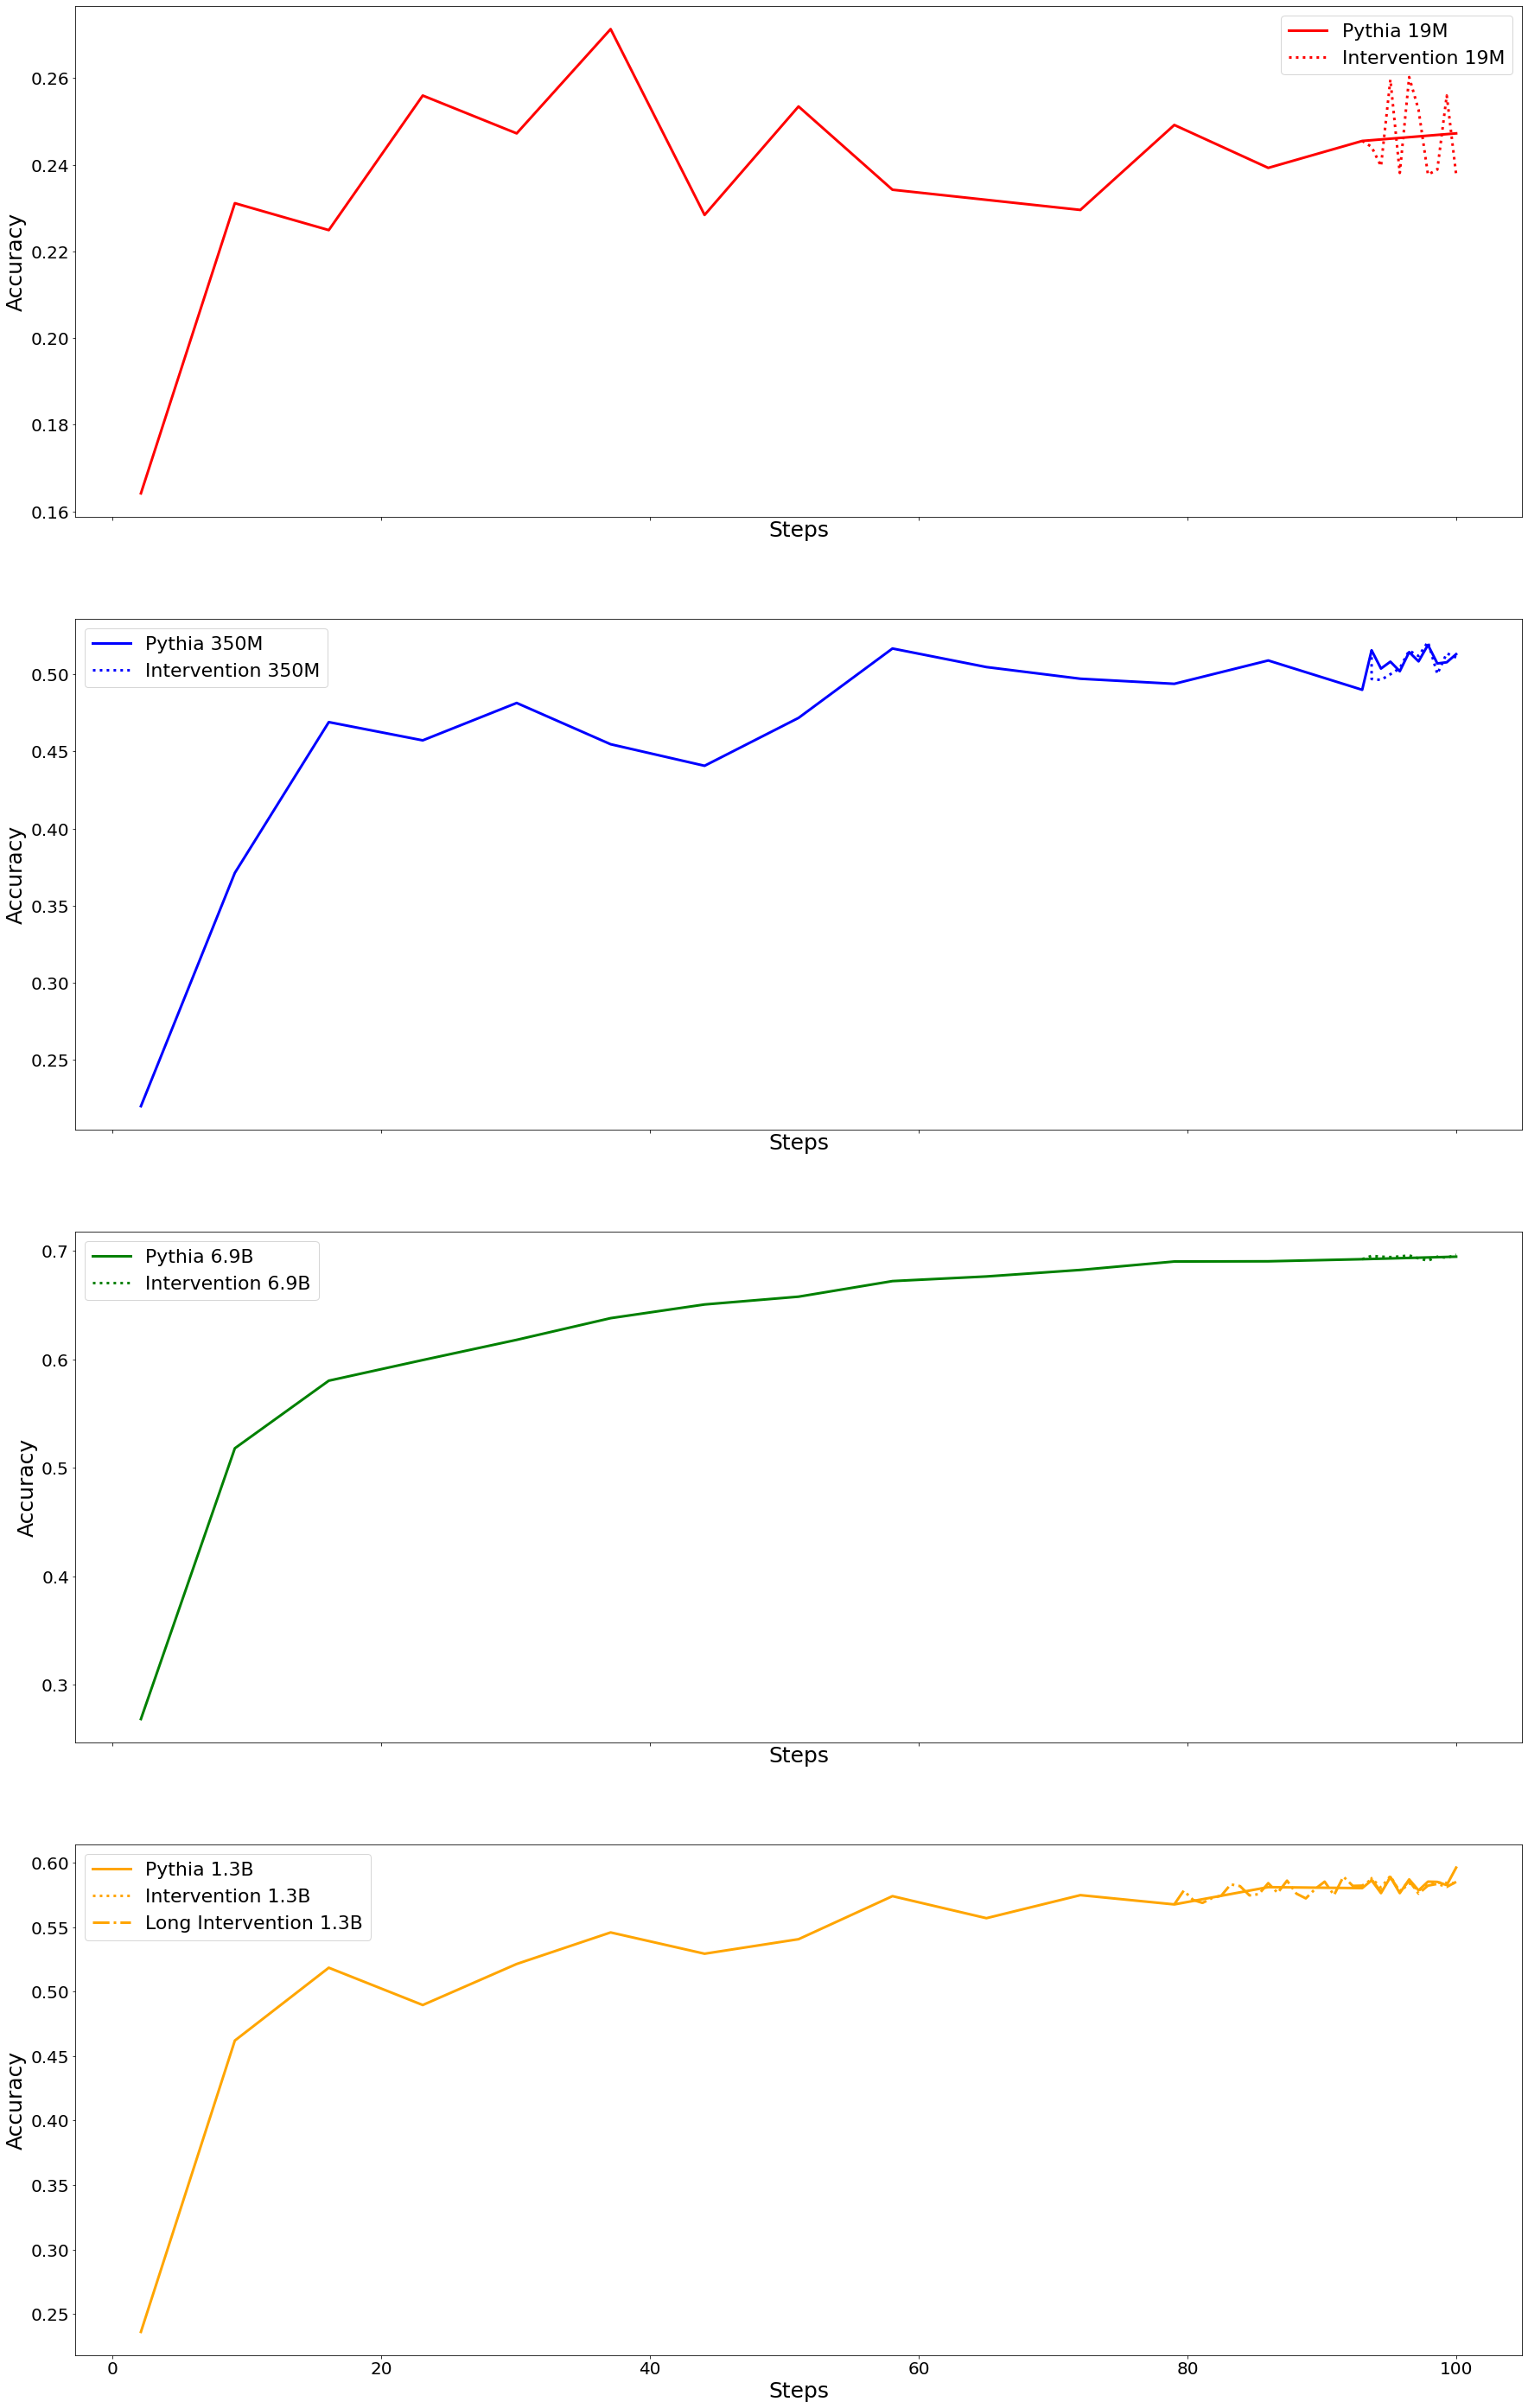

In [200]:
# plot_4_subplots(pythia_res, intervened_res, long_intervened_res, 'lambada_openai', [['19m'], ['350m'], ['6.9b'], ['1.3b']], 'lambada_openai_plots/lambada_openai_4_plots.pdf', normalize=True)